In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [3]:
#{"DX": [], "DY": [], "DZ": [], "H": [], "log_f": [], "RP": []})
DATA = pd.read_csv("DATA/data.csv")
DATA.pop("Unnamed: 0")

ROW_NUM = len(DATA.index)
print(ROW_NUM)
TRAINING_NUM = int(ROW_NUM / 10 * 7)
VALIDATION_NUM = int(ROW_NUM / 20 * 3 )

TRAINING_DATA = DATA.iloc[ :TRAINING_NUM,:]
VALIDATION_DATA = DATA.iloc[TRAINING_NUM:TRAINING_NUM+VALIDATION_NUM,:]
TEST_DATA = DATA.iloc[TRAINING_NUM+VALIDATION_NUM:,:]
TRAINING_VAL = pd.DataFrame(TRAINING_DATA.pop('RP'))
VALIDATION_VAL = pd.DataFrame(VALIDATION_DATA.pop('RP'))
TEST_VAL = pd.DataFrame(TEST_DATA.pop('RP'))

DATA.pop('RP')


452864


0        -117.750391
1         -69.327201
2        -106.181961
3        -112.981354
4        -128.770041
             ...    
452859   -135.552306
452860   -155.180482
452861   -105.433740
452862   -151.030553
452863   -179.902905
Name: RP, Length: 452864, dtype: float64

In [4]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
min_max_scaler.fit(DATA)
joblib.dump(min_max_scaler, "MLP.scaler.gz") 

TRAINING_DATA = min_max_scaler.transform(TRAINING_DATA)
TRAINING_DATA = pd.DataFrame(TRAINING_DATA)
VALIDATION_DATA = min_max_scaler.transform(VALIDATION_DATA)
VALIDATION_DATA = pd.DataFrame(VALIDATION_DATA)
TEST_DATA = min_max_scaler.transform(TEST_DATA)
TEST_DATA = pd.DataFrame(TEST_DATA)

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(160,activation="tanh", input_dim=5),
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss="mean_squared_error", optimizer='adam')

epochs=10000
batch=100


model_name = f"{model.layers[0].input_shape[1]}"
for layer in model.layers:
    model_name+=f"-{layer.output_shape[1]}"
model_name += f"_e:{epochs}_b:{batch}"
print(model_name)

5-160-1_e:10000_b:100


2022-05-20 00:04:09.864547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10000
3171/3171 [==============================] - 3s 761us/step - loss: 1713.1350 - val_loss: 94.7106
Epoch 2/10000
3171/3171 [==============================] - 2s 718us/step - loss: 56.9031 - val_loss: 38.8389
Epoch 3/10000
3171/3171 [==============================] - 2s 720us/step - loss: 34.1970 - val_loss: 31.5983
Epoch 4/10000
3171/3171 [==============================] - 2s 710us/step - loss: 25.9857 - val_loss: 19.3165
Epoch 5/10000
3171/3171 [==============================] - 2s 719us/step - loss: 16.0910 - val_loss: 14.0462
Epoch 6/10000
3171/3171 [==============================] - 2s 718us/step - loss: 12.9539 - val_loss: 12.0839
Epoch 7/10000
3171/3171 [==============================] - 2s 705us/step - loss: 11.4687 - val_loss: 11.1563
Epoch 8/10000
3171/3171 [==============================] - 2s 719us/step - loss: 10.6556 - val_loss: 10.4305
Epoch 9/10000
3171/3171 [==============================] - 3s 822us/step - loss: 10.1149 - val_loss: 10.0400
Epoch 10/10000
31

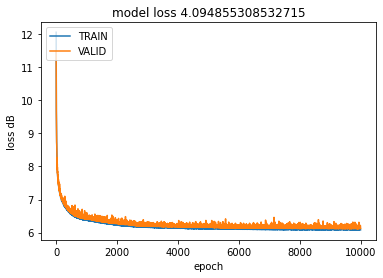

In [6]:
history = model.fit(TRAINING_DATA, TRAINING_VAL, epochs=epochs, batch_size=batch, validation_data=(VALIDATION_DATA, VALIDATION_VAL))
model.save(f"MODELS/{model_name}.h5")

from math import log10

scores = model.evaluate(TEST_DATA, TEST_VAL, batch_size=20)
plt.plot([10*log10(loss) for loss in history.history['loss'][4:]])
plt.plot([10*log10(loss) for loss in history.history['val_loss'][4:]])
plt.title(f'model loss {scores}')
plt.ylabel('loss dB')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VALID'], loc='upper left')
plt.savefig(f"TRAINING_PROCESS/{model_name}.png")
plt.show()


In [16]:
TEST_DATA = TEST_DATA.iloc[:30,:]
PREDICTIONS = pd.DataFrame(model.predict(TEST_DATA))
PREDICTIONS.columns=["PREDICITONS"]

TEST_VAL = TEST_VAL.iloc[:30,:]
TEST_VAL.columns=["TEST_VAL"]
TEST_VAL = TEST_VAL.reset_index(drop=True)

result=pd.concat([PREDICTIONS, TEST_VAL], axis=1)
result["ERROR"] = result["PREDICITONS"] - result["TEST_VAL"]
result.to_csv("MLP.csv")
